In [3]:
#%% 1.1

import os
import numpy as np
import matplotlib.pyplot as plt
from seaborn import cubehelix_palette, heatmap
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor
import deeplay as dl
import torchmetrics as tm
from skimage.transform import resize
from skimage.exposure import rescale_intensity
import random

# Load MNIST data
if not os.path.exists("MNIST_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/MNIST_dataset")

train_path = os.path.join("MNIST_dataset", "mnist", "train")
train_image_files = sorted(os.listdir(train_path))
test_path = os.path.join("MNIST_dataset", "mnist", "test")
test_image_files = sorted(os.listdir(test_path))

# Dataset with one-hot encoding
class MNISTOneHotDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.num_classes = 10  # MNIST has 10 classes

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        # Convert label to one-hot encoding
        one_hot_label = torch.nn.functional.one_hot(torch.tensor(label, dtype=torch.long), num_classes=self.num_classes).float()
        
        return image, one_hot_label

transform = Compose([ToTensor()])

# Prepare training data
train_images = [plt.imread(os.path.join(train_path, file)) for file in train_image_files] #List of numpy array
train_digits = [int(os.path.basename(file)[0]) for file in train_image_files]
train_dataset = MNISTOneHotDataset(train_images, train_digits, transform=transform) #Makes into dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #Wraps into loader and shuffles data

# Prepare test data
test_images = [plt.imread(os.path.join(test_path, file)) for file in test_image_files]
test_digits = [int(os.path.basename(file)[0]) for file in test_image_files]
test_dataset = MNISTOneHotDataset(test_images, test_digits, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


conv_base = dl.ConvolutionalNeuralNetwork(
    in_channels=1,
    hidden_channels=[16, 16, 32],
    out_channels=32,
)
conv_base.blocks[2].pool.configure(torch.nn.MaxPool2d, kernel_size=2)

connector = dl.Layer(torch.nn.AdaptiveAvgPool2d, output_size=1)

dense_top = dl.MultiLayerPerceptron(
    in_features=32,
    hidden_features=[],
    out_features=10,
    out_activation=torch.nn.Softmax(dim=1), 
)

cnn = dl.Sequential(conv_base, connector, dense_top)

# Using categorical crossentropy loss since Softmax activation
cnn_classifier = dl.Classifier(
    model=cnn,
    optimizer=dl.RMSprop(lr=0.001),
    metrics=[tm.Accuracy(task="multilabel", num_labels=10)],
).create()

In [4]:
#%% Training and testing 1.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # If cuda available
print(f"Using device: {device}")

cnn_classifier = cnn_classifier.to(device)

cnn_trainer = dl.Trainer(max_epochs=5, accelerator="auto", devices = "auto")
cnn_trainer.fit(cnn_classifier, train_loader)

# Test
test_results = cnn_trainer.test(cnn_classifier, test_loader)

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_m

Using device: cuda
Epoch 4: 100%|██████████| 1875/1875 [00:12<00:00, 150.98it/s, v_num=50, train_loss_step=1.480, trainMultilabelAccuracy_step=0.994, train_loss_epoch=1.540, trainMultilabelAccuracy_epoch=0.985]

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 215.45it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMultilabelAccuracy_epoch │      0.9858199954032898      │
│       test_loss_epoch        │      1.5341399908065796      │
└──────────────────────────────┴──────────────────────────────┘

In [ ]:
#%% 1.2

def grad_cam_multiclass(model, image, layer=None):
    # Register hooks
    hookdata = {}
    
    def fwd_hook(layer, input, output):
        hookdata["activations"] = output.detach()
    
    def bwd_hook(layer, grad_input, grad_output):
        hookdata["gradients"] = grad_output[0].detach()
    
    # Default to last convolutional layer if not specified
    if layer is None:
        layer = model[0].blocks[-1].layer
    
    # Register hooks
    handle_fwd = layer.register_forward_hook(fwd_hook)
    handle_bwd = layer.register_full_backward_hook(bwd_hook)
    
    # Forward pass
    image_tensor = image.unsqueeze(0)  # Add batch dim
    logits = model(image_tensor)
    probs = torch.softmax(logits, dim=1)
    
    predicted_class = torch.argmax(probs).item()
    
    # Zero gradients, then backward pass for target class
    model.zero_grad()
    logits[0, predicted_class].backward(retain_graph=True)
    
    # Remove hooks
    handle_fwd.remove()
    handle_bwd.remove()
    
    # Get activations and gradients
    activations = hookdata["activations"][0]  # Shape: (C, H, W)
    gradients = hookdata["gradients"][0]      # Shape: (C, H, W)
    
    # Compute Grad-CAM
    pooled_gradients = gradients.mean(dim=[1, 2], keepdim=True)
    heatmap = (pooled_gradients * activations).sum(dim=0)
    heatmap = torch.relu(heatmap).detach().numpy()
    
    # Resize heatmap to match input image
    heatmap_resized = resize(heatmap, image.shape[1:], order=3)  # bicubic interpolation
    heatmap_rescaled = rescale_intensity(heatmap_resized, out_range=(0, 1))
    
    return heatmap_rescaled, predicted_class

# --- Visualization Function ---
def plot_gradcam(image, heatmap, target_class, true_class):
    """Plot original image, heatmap, and overlay."""
    plt.figure(figsize=(12, 4))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0).squeeze(), cmap="gray")
    plt.title(f"Input (True: {true_class})", fontsize=12)
    plt.axis("off")
    
    # Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap="viridis")
    plt.title(f"Grad-CAM (Class: {target_class})", fontsize=12)
    plt.axis("off")
    
    # Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(image.permute(1, 2, 0).squeeze(), cmap="gray")
    plt.imshow(heatmap, cmap="viridis", alpha=0.5)
    plt.title("Overlay", fontsize=12)
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

def get_test_images_by_class(test_loader, target_class):
    """Extract all test images of a specific class."""
    images = []
    for batch_images, batch_labels in test_loader:
        # Convert one-hot labels to class indices
        class_indices = torch.argmax(batch_labels, dim=1)
        # Filter images of the target class
        mask = (class_indices == target_class)
        images.extend(batch_images[mask])
    return images

C:\Users\Green\AppData\Local\Temp\ipykernel_22556\2732837576.py:70: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(image * heatmap, cmap="gray")


TypeError: Invalid shape (1, 28, 28) for image data

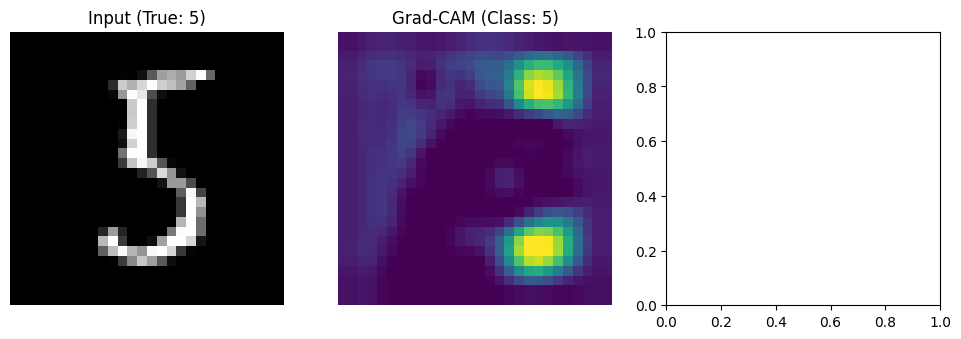

In [8]:
#%% Printing heatmaps

wrong_counter = 0
sample_range = 1

for i in range(sample_range):
    target_digit = 5
    digit_images = get_test_images_by_class(test_loader, target_digit)

    selected_image = random.choice(digit_images)

    heatmap, pred_class = grad_cam_multiclass(cnn_classifier.model, selected_image)

    plot_gradcam(selected_image, heatmap, pred_class, target_digit)

    print(f"True class: {target_digit}, Predicted class: {pred_class}")
    if target_digit != pred_class:
        wrong_counter += 1

#print(f'Worong conter: {wrong_counter}')

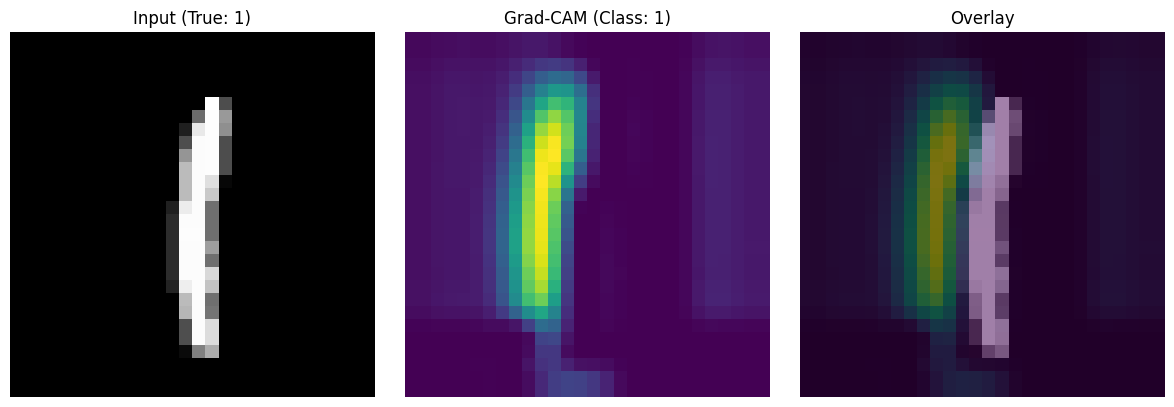

True class: 1, Predicted class: 1


In [ ]:
#%%

wrong_counter = 0
sample_range = 1

for i in range(sample_range):
    target_digit = 1
    digit_images = get_test_images_by_class(test_loader, target_digit)

    selected_image = random.choice(digit_images)

    heatmap, pred_class = grad_cam_multiclass(cnn_classifier.model, selected_image)

    plot_gradcam(selected_image, heatmap, pred_class, target_digit)

    print(f"True class: {target_digit}, Predicted class: {pred_class}")
    if target_digit != pred_class:
        wrong_counter += 1

#print(f'Worong conter: {wrong_counter}')

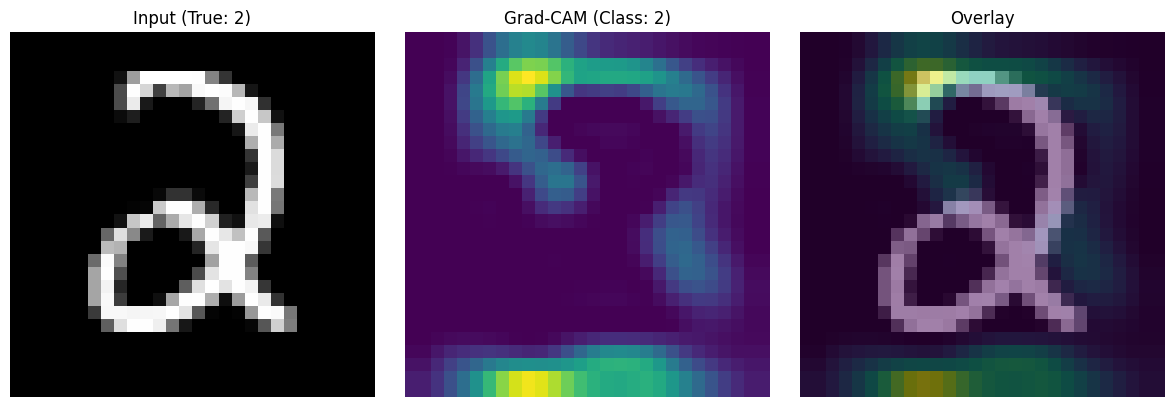

True class: 2, Predicted class: 2


In [ ]:
#%%

wrong_counter = 0
sample_range = 1

for i in range(sample_range):
    target_digit =2
    digit_images = get_test_images_by_class(test_loader, target_digit)

    selected_image = random.choice(digit_images)

    heatmap, pred_class = grad_cam_multiclass(cnn_classifier.model, selected_image)

    plot_gradcam(selected_image, heatmap, pred_class, target_digit)

    print(f"True class: {target_digit}, Predicted class: {pred_class}")
    if target_digit != pred_class:
        wrong_counter += 1

#print(f'Worong conter: {wrong_counter}')

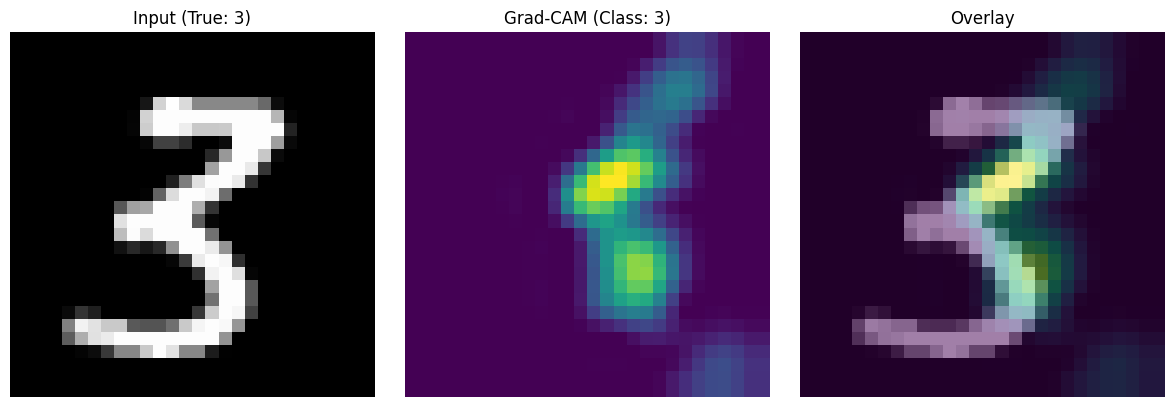

True class: 3, Predicted class: 3


In [ ]:
#%%

wrong_counter = 0
sample_range = 1

for i in range(sample_range):
    target_digit =3
    digit_images = get_test_images_by_class(test_loader, target_digit)

    selected_image = random.choice(digit_images)

    heatmap, pred_class = grad_cam_multiclass(cnn_classifier.model, selected_image)

    plot_gradcam(selected_image, heatmap, pred_class, target_digit)

    print(f"True class: {target_digit}, Predicted class: {pred_class}")
    if target_digit != pred_class:
        wrong_counter += 1

#print(f'Worong conter: {wrong_counter}')

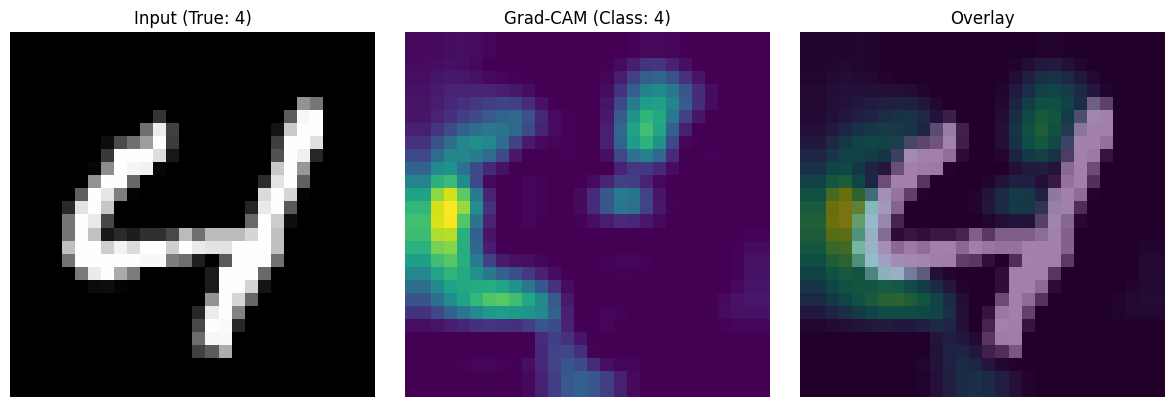

True class: 4, Predicted class: 4


In [ ]:
#%%

wrong_counter = 0
sample_range = 1

for i in range(sample_range):
    target_digit =4
    digit_images = get_test_images_by_class(test_loader, target_digit)

    selected_image = random.choice(digit_images)

    heatmap, pred_class = grad_cam_multiclass(cnn_classifier.model, selected_image)

    plot_gradcam(selected_image, heatmap, pred_class, target_digit)

    print(f"True class: {target_digit}, Predicted class: {pred_class}")
    if target_digit != pred_class:
        wrong_counter += 1

#print(f'Worong conter: {wrong_counter}')

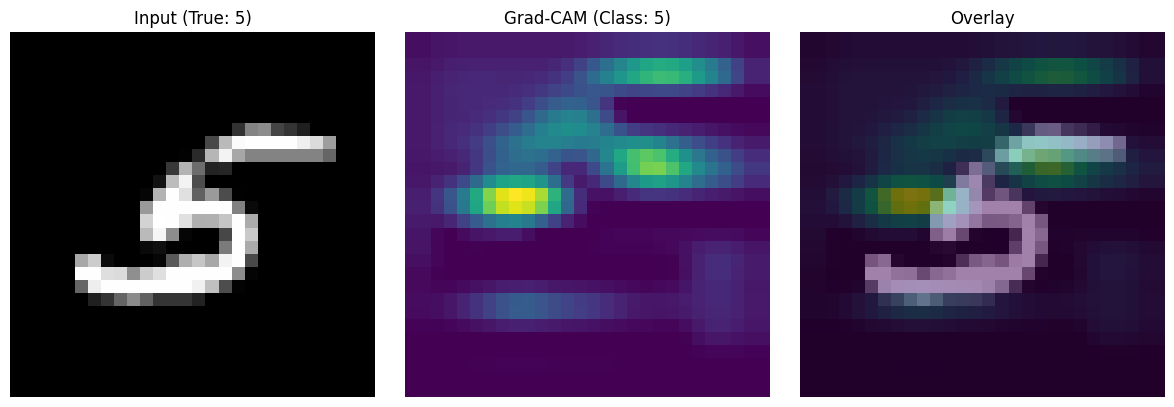

True class: 5, Predicted class: 5


In [ ]:
#%%

wrong_counter = 0
sample_range = 1

for i in range(sample_range):
    target_digit =5
    digit_images = get_test_images_by_class(test_loader, target_digit)

    selected_image = random.choice(digit_images)

    heatmap, pred_class = grad_cam_multiclass(cnn_classifier.model, selected_image)

    plot_gradcam(selected_image, heatmap, pred_class, target_digit)

    print(f"True class: {target_digit}, Predicted class: {pred_class}")
    if target_digit != pred_class:
        wrong_counter += 1

#print(f'Worong conter: {wrong_counter}')

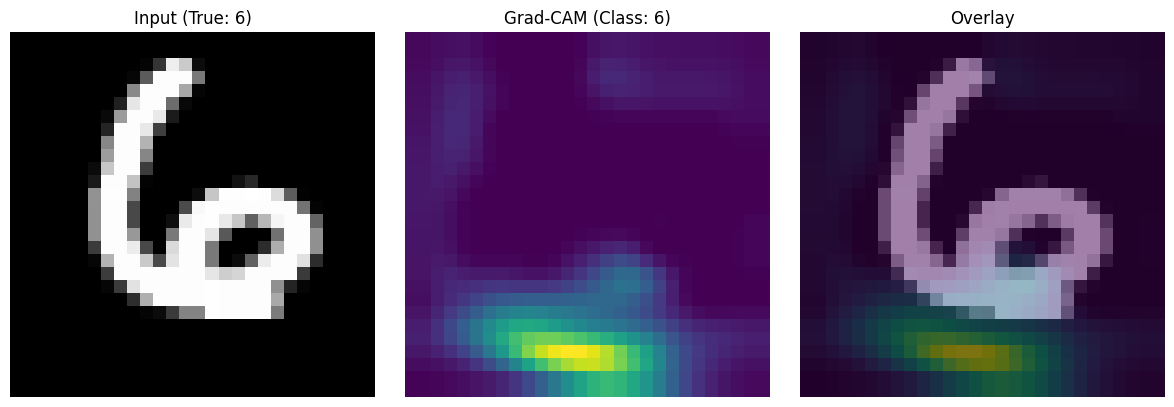

True class: 6, Predicted class: 6


In [ ]:
#%%

wrong_counter = 0
sample_range = 1

for i in range(sample_range):
    target_digit =6
    digit_images = get_test_images_by_class(test_loader, target_digit)

    selected_image = random.choice(digit_images)

    heatmap, pred_class = grad_cam_multiclass(cnn_classifier.model, selected_image)

    plot_gradcam(selected_image, heatmap, pred_class, target_digit)

    print(f"True class: {target_digit}, Predicted class: {pred_class}")
    if target_digit != pred_class:
        wrong_counter += 1

#print(f'Worong conter: {wrong_counter}')

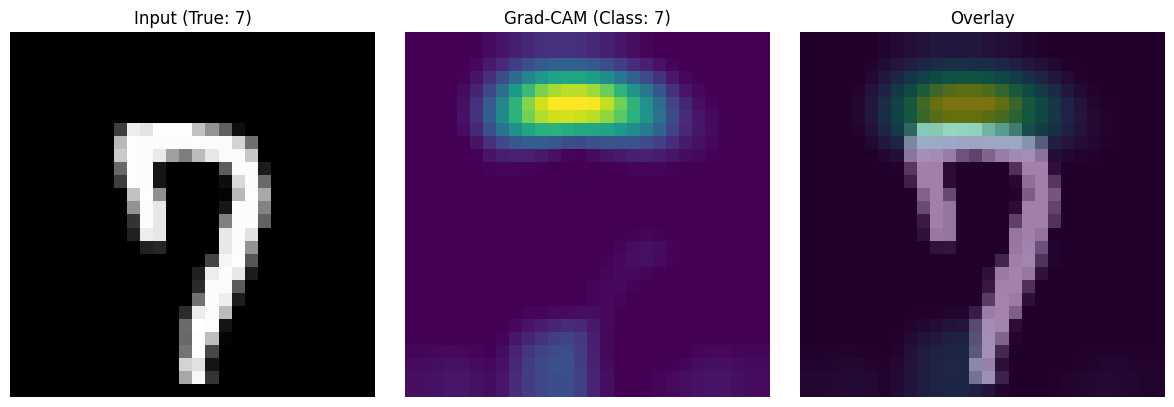

True class: 7, Predicted class: 7


In [ ]:
#%%

wrong_counter = 0
sample_range = 1

for i in range(sample_range):
    target_digit =7
    digit_images = get_test_images_by_class(test_loader, target_digit)

    selected_image = random.choice(digit_images)

    heatmap, pred_class = grad_cam_multiclass(cnn_classifier.model, selected_image)

    plot_gradcam(selected_image, heatmap, pred_class, target_digit)

    print(f"True class: {target_digit}, Predicted class: {pred_class}")
    if target_digit != pred_class:
        wrong_counter += 1

#print(f'Worong conter: {wrong_counter}')

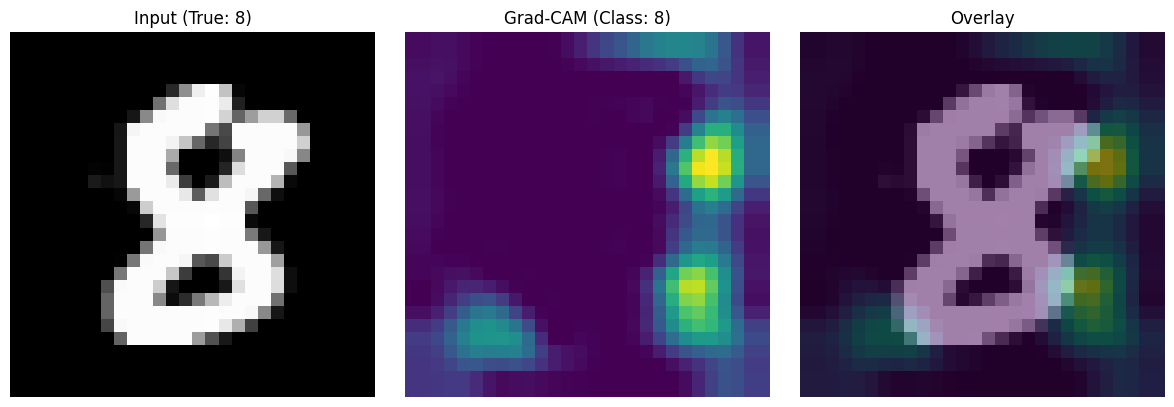

True class: 8, Predicted class: 8


In [ ]:
#%%

wrong_counter = 0
sample_range = 1

for i in range(sample_range):
    target_digit =8
    digit_images = get_test_images_by_class(test_loader, target_digit)

    selected_image = random.choice(digit_images)

    heatmap, pred_class = grad_cam_multiclass(cnn_classifier.model, selected_image)

    plot_gradcam(selected_image, heatmap, pred_class, target_digit)

    print(f"True class: {target_digit}, Predicted class: {pred_class}")
    if target_digit != pred_class:
        wrong_counter += 1

#print(f'Worong conter: {wrong_counter}')

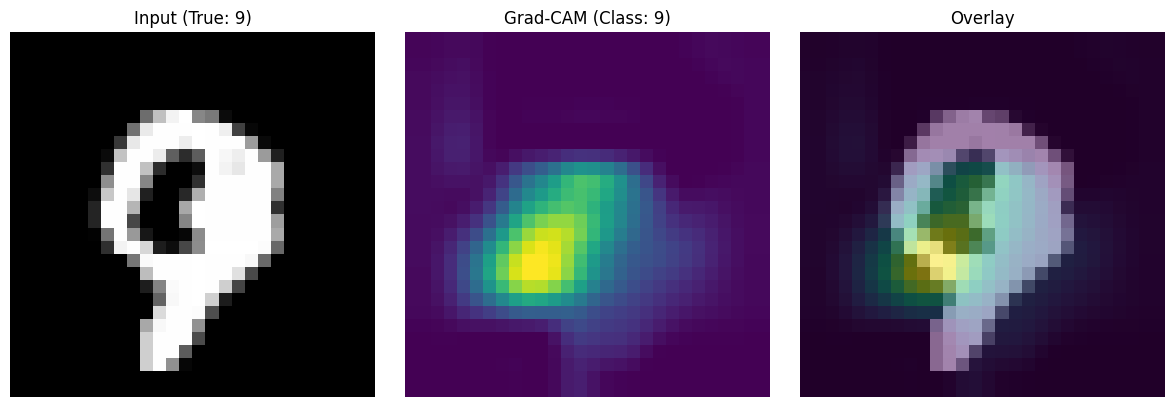

True class: 9, Predicted class: 9


In [ ]:
#%%

wrong_counter = 0
sample_range = 1

for i in range(sample_range):
    target_digit =9
    digit_images = get_test_images_by_class(test_loader, target_digit)

    selected_image = random.choice(digit_images)

    heatmap, pred_class = grad_cam_multiclass(cnn_classifier.model, selected_image)

    plot_gradcam(selected_image, heatmap, pred_class, target_digit)

    print(f"True class: {target_digit}, Predicted class: {pred_class}")
    if target_digit != pred_class:
        wrong_counter += 1

#print(f'Worong conter: {wrong_counter}')

-1